# REIT ETFs Price Prediction

<img src="images/stock.jpeg">

## I. Overview
This project uses a regression model for forecasting future prices and a classification model to predict the trend for REIT ETFs. The historical data acquired from Yahoo Finance contains up-to-date price information. Potential investors can use my models to predict both future prices and trends.

## II. Business Problem
### Motivation
Invest in real estate over long term could offer a reliable stream of income. This could also offer the benefit of tax reduction, direct ownership, potential growth of net worth, and so on. But those benefits come with a lot of hands-on responsibilities. Invest in REIT ETFs (Real Estate Investment Trust Exchange-Traded Funds) offer a low investment requirement and hands-off (but less control) way to earn dividends quarterly by purchasing baskets of stocks.

***

### Goal
Predict future price and trend through machine learning.


## III. Data Understanding
The historical price data from [Yahoo Finance](https://finance.yahoo.com/) are free to acquire through [yfinance API](https://pypi.org/project/yfinance/). Here, I focused on [Top 28 REIT ETFs](https://etfdb.com/etfdb-category/real-estate/) for further analysis. The last date for all ETFs was 06/23/2021.

### Jupyter Notebook Instruction
In the Github repository, there is a "notebook" folder. Follow by the order:
1. Fetch_Data.ipynb
    - The main purpose of this notebook is to fetch mutiple REIT ETFs' historical data from Yahoo Finance and combine them into a single dataframe
    - The data set contains `OHLC` (Open, High, Low, Close), `Volume`, `Dividends`, `Stock Splits` and `Ticker`
2. ARIMA.ipynb
    - An ARIMA model was built for VNQ
    - Train-Val-Test split
        - Train set was used for training the model
        - Validation set was used for checking the model performance after ML
        - Test set was only used once for checking the model performance on unseen data
3. FBProphet.ipynb
    - A FBProphet model was built for VNQ
    - (Due to the nature of FBProphet, data split is slightly different than other models)
    - Train-Test Split
        - Train set was used for training the model
        - Test set was only used once for checking the model performance on unseen data
    
4. LSTM.ipynb
    - A LSTM model was built for VNQ
    - Train-Val-Test split
        - Train set was used for training the model
        - Validation set was used for tuning the model
        - Test set was only used once for checking the model performance on unseen data
5. Classification.ipynb
    - <b>nusvc_clf</b>, the best model, was selected among 9 differnent classfiers for VNQ
    - Train-Val-Test split
        - Train set was used for training the model
        - Validation set was used for tuning the model
        - Test set was only used once for checking the model performance on unseen data


### Note
- For convinence, there is a py file which contains pre-written functions
- Both regression and classification models are built on <b>VNQ</b>
- Full detail on how to tune the model can be viewed in the corresponding notebook



### Regression Results for Test Set
|  Model | MAE | RMSE | R2 | Choice |
| :---: | :---: |:---: | :---: |:---: | 
| ARIMA | 4.6429 | 5.0535 | -4.9348 |  |
| FBProphet | 14.0614 | 14.1760 | -51.0399 |  |
| LSTM | 0.7419 | 0.9534 | 0.7756 | ✓ |

- LSTM is the best regression model for forecating future's prices

### Classification Results for Test Set
|  Model | Accuracy | ROC-AUC | F1 (0) | F1 (1) |
| :---: | :---: |:---: | :---: |:---: | 
| NuSVC | 0.9091 | 0.9500 | 0.90 | 0.92 |


- NuSVC is the best classifier for predicting future's trend

## IV. Google Colab Setup

In [1]:
# util.py has pmdarima function inside
# Need to install it before import the pyfile
# !pip install pmdarima

In [2]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pickle import dump, load

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Keras, Tensorflow
from tensorflow.keras.models import load_model

# Plotly
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
# Get the current working directory
print(os.getcwd())

/content


In [5]:
# Upload drive path file
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'
drive_path_lstm = '/gdrive/MyDrive/Capstone_Project/f150.h5'
drive_path_nusvc = '/gdrive/MyDrive/Capstone_Project/nusvc.pkl'

# Expect to move these file into the local path
local_path = '/content'

In [6]:
# Copy these file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .
!cp '{drive_path_lstm}' .
!cp '{drive_path_nusvc}' .

# Change these file from drive path to the local path
os.chdir(local_path)

In [7]:
# Pre-written function
import util as ut

## V. Preprocessing

In [8]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.7945,23.8614,23.7898,23.7945,205800,0.0000,0.0000,VNQ
1,2004-09-30,23.8661,24.0237,23.8614,23.9855,27900,0.0000,0.0000,VNQ
2,2004-10-01,24.0332,24.4628,23.9855,24.4294,129800,0.0000,0.0000,VNQ
3,2004-10-04,24.5296,24.6060,24.5296,24.5344,8100,0.0000,0.0000,VNQ
4,2004-10-05,24.5344,24.5821,24.5105,24.5296,11900,0.0000,0.0000,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.2800,9.2900,9.2200,9.2200,5200,0.0000,0.0000,REK
53435,2021-06-18,9.3300,9.3700,9.2700,9.3700,22800,0.0000,0.0000,REK
53436,2021-06-21,9.3200,9.3200,9.1700,9.1700,22900,0.0000,0.0000,REK
53437,2021-06-22,9.1600,9.2300,9.1600,9.2200,6200,0.0000,0.0000,REK


In [9]:
# Put all tickers in a list
ticker = [x for x in data['Ticker'].unique()]
ticker

['VNQ',
 'IYR',
 'SCHH',
 'ICF',
 'USRT',
 'RWR',
 'REM',
 'REZ',
 'KBWY',
 'MORT',
 'PSR',
 'FRI',
 'ROOF',
 'RDOG',
 'REK']

In [10]:
# Visualize 15 REIT ETFs' closing price
fig = px.area(data, x='Date', y='Close', facet_col="Ticker", color="Ticker",
              facet_col_wrap=3, height=1000, width=1500)                    # (or use px.line to see the line w/o under area)

# Save interative plot
fig.write_html("/content/15_close.html")
fig.show()

### Note:
- The above interactive plot can be only viewed in Google Colab. For visualization on Github, a static plot will be shown instead

<img src="images/15_close.png">

>**Comment:** *Plotly interative plot*
- The closing price range varies differently among 15 REIT ETFs
- Some the ETFs have similar trend as VNQ (sharp slope), while some of them have relative flat slop. REK is the only one has a decrease trend

In [11]:
def xy_split_reg (dataset, timestep):
    '''
    (Regression)

    Split the time series into X and y part based on the number of timestep.
    Ex. Use n days to predict the next preceding day (n+1) price.
    
    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - dataset: Time series data
    - timestep: number of days in integer
    
    Return: 
    - X_part, y_part (in arrays)
    '''
    
    X_part, y_part = [], []
    
    for i in range(len(dataset)-timestep-1):
         
        X_part.append(dataset[i:(i+timestep)])

        y_part.append(dataset[i+timestep])

    return np.array(X_part), np.array(y_part)



def xy_split_class(dataset):
    '''
    (Classification)

    Split the dataset into X-part and y-part(label).

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    
    Input:
    - dataset: Time series data

    Return:
    - X_part, y_part
    
    '''

    X = dataset.drop(columns=['Trend'], axis=1)
    y = dataset['Trend']

    return X, y

## VI. Modeling

In [12]:
def etf_reg(ticker_name):
    '''
    (Regression)

    Create a sub-df from select ticker. Preprocessed the sub-df and use LSTM model
    on test set to predict the future price. Evaluate the test result.

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    
    Input:
    - ticker_name: 3-letters capital symbol

    Output:
    - Preprocessed df, time series plot, LSTM test prediction result with MAE, RMSE, R2, and plot
    
    '''

    # Create a sub df for selected ticker
    etf = data.copy().loc[data['Ticker'] == ticker_name]
    
    # Use pre-defined function to set the "Date" as index in datetime64
    ut.preprocess_df(etf)

    # Plot the time series
    # ut.visualize_time_series(etf['Close'], ticker_name)

    # Train test split (Note: train set is for the scaler!)
    train = etf['Close'].iloc[:-275]
    test = etf['Close'].iloc[-22:]

    # Instantiate the scaler    
    scaler = MinMaxScaler()

    # Scale
    train_scale = scaler.fit_transform(train.values.reshape(-1,1))
    test_scale = scaler.transform(test.values.reshape(-1,1))

    # Split the test set into X, y part
    X_test, y_test = xy_split_reg(test_scale, timestep=1)

    # Load the best LSTM model
    best = load_model('/content/f150.h5')

    # Make prediction on the holdout test set
    y_test_pred = best.predict(X_test)

    # Inverse transform the test prediction and actual
    y_test_inv = scaler.inverse_transform(y_test_pred) # pred
    y_test_true = scaler.inverse_transform(y_test)     # actual


    # Evaluate MAE, RMSE, and R2
    ut.evaluate(y_test_true, y_test_inv)

    # Plot test result
    ut.lstm_plot_prediction(y_test_true, y_test_inv)
    

   


def etf_class(ticker_name):
    '''
    (Classification)

    Create a sub-df from select ticker. Preprocessed the sub-df and use NuSVC model
    on test set to predict the future trend. Evaluate the test result.

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    
    Input: 
    - ticker_name: 3-letters capital symbol
    
    Output:
    - Preprocessed df, NuSVC test prediction with accuracy, roc-auc, classification report, confusion matrix and roc-curve

    '''   

    # Create a sub df for selected ticker
    etf = data.copy().loc[data['Ticker'] == ticker_name]
    
    # Drop unecessary columns
    etf.drop(columns=['Volume', 'Dividends', 'Stock Splits', 'Ticker'], inplace=True)
    
    # Shift index by 1 period => lag-1
    etf['Lag 1'] = etf['Close'].shift(periods=1)
    
    # Find the difference between closing price and lag-1
    etf.loc[etf['Close'] - etf['Lag 1'] > 0, 'Trend'] = 'up'
    etf.loc[etf['Close'] - etf['Lag 1'] <= 0, 'Trend'] = 'down'
    
    # Drop unecessary column and the 1st row (which has null value)
    etf.drop(columns=['Lag 1'], inplace=True)
    etf.drop(etf.index.min(), inplace=True)
    
    # Use pre-defined function to set the "Date" as index in datetime64
    ut.preprocess_df(etf)

    # Label Encoding
    label_encoder = LabelEncoder()
    etf['Trend']= label_encoder.fit_transform(etf['Trend'])
    
    # Split the data
    test = etf.iloc[-22:]
    X_test, y_test = xy_split_class(test)

    # Load the best NuSVC classifier
    best = load(open('/content/nusvc.pkl', 'rb'))


    # Evaluate accuracy, roc-auc score, classification report, confusion matrix and roc-curve
    ut.class_evaluate(best, X_test, y_test, use_decision_function='yes')
    

    

def etf(ticker_name):
    '''
    Manually input ticker name from given list and call regression and classification functions

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    
    Input:
    - symbol from given list

    Output:
    - regression result and classification result on test set

    '''
    
    # print("Select one REIT ETF from the following list: \n")
    # for i in range(0,15):
        # print(f"{i+1}. {ticker[i]}")  # ticker list

    # print("\n")
    # ticker_name = input("Which REIT ETF do you want to predict? \n").upper()

    reg_result = etf_reg(ticker_name)
    class_result = etf_class(ticker_name)

### 15 REIT ETFs Result

VNQ
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2004-09-29,23.7945,23.8614,23.7898,23.7945,205800,0.0000,0.0000,VNQ
2004-09-30,23.8661,24.0237,23.8614,23.9855,27900,0.0000,0.0000,VNQ
2004-10-01,24.0332,24.4628,23.9855,24.4294,129800,0.0000,0.0000,VNQ
2004-10-04,24.5296,24.6060,24.5296,24.5344,8100,0.0000,0.0000,VNQ
2004-10-05,24.5344,24.5821,24.5105,24.5296,11900,0.0000,0.0000,VNQ
...,...,...,...,...,...,...,...,...
2021-06-17,103.4100,103.7000,102.8600,103.5500,5055100,0.0000,0.0000,VNQ
2021-06-18,103.0200,103.4700,101.7900,101.7900,5358000,0.0000,0.0000,VNQ
2021-06-21,102.3100,104.2100,101.8000,103.8900,3672900,0.0000,0.0000,VNQ


MAE: 0.7335
RMSE: 0.9228
R^2: 0.7897


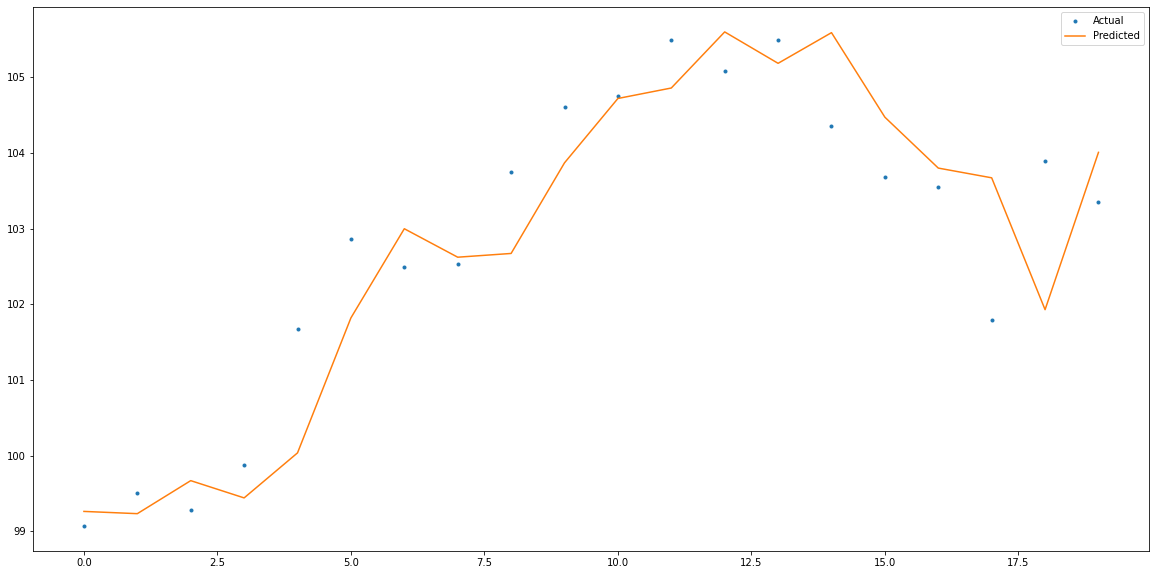

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2004-09-30,23.8661,24.0237,23.8614,23.9855,up
2004-10-01,24.0332,24.4628,23.9855,24.4294,up
2004-10-04,24.5296,24.6060,24.5296,24.5344,up
2004-10-05,24.5344,24.5821,24.5105,24.5296,down
2004-10-06,24.5821,24.6442,24.5774,24.6442,up
...,...,...,...,...,...
2021-06-17,103.4100,103.7000,102.8600,103.5500,down
2021-06-18,103.0200,103.4700,101.7900,101.7900,down
2021-06-21,102.3100,104.2100,101.8000,103.8900,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.9091
roc-auc: 0.9500
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.92      0.92      0.92        12

    accuracy                           0.91        22
   macro avg       0.91      0.91      0.91        22
weighted avg       0.91      0.91      0.91        22



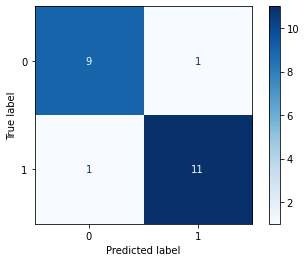

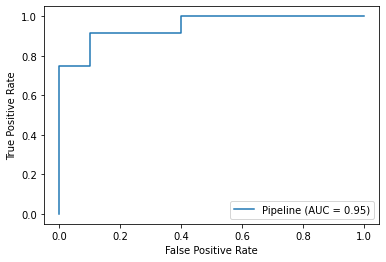

IYR
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2000-06-19,14.4951,14.4951,14.4951,14.4951,200,0.0000,0.0000,IYR
2000-06-20,14.5339,14.5565,14.5339,14.5565,400,0.0000,0.0000,IYR
2000-06-21,14.6438,14.6438,14.6276,14.6276,20600,0.0000,0.0000,IYR
2000-06-22,14.6341,14.6341,14.6341,14.6341,400,0.0000,0.0000,IYR
2000-06-23,14.6341,14.6341,14.6341,14.6341,0,0.0000,0.0000,IYR
...,...,...,...,...,...,...,...,...
2021-06-17,102.7200,103.1900,102.3400,103.0400,9029000,0.0000,0.0000,IYR
2021-06-18,102.7600,102.9800,101.3800,101.4100,7828200,0.0000,0.0000,IYR
2021-06-21,101.7000,103.7300,101.4600,103.4700,6758900,0.0000,0.0000,IYR


MAE: 0.6964
RMSE: 0.8815
R^2: 0.7768


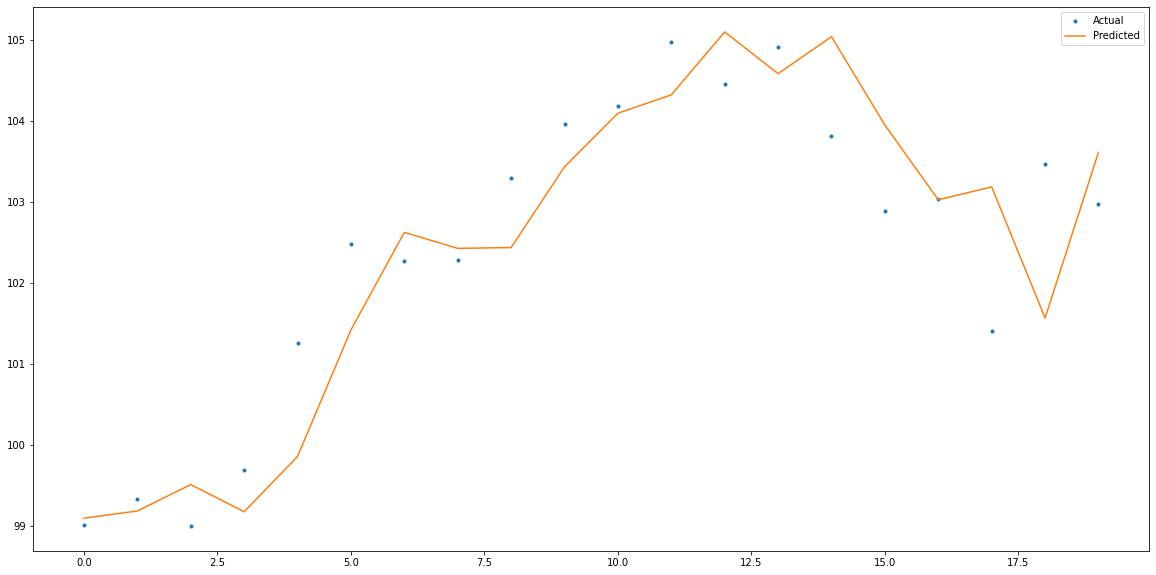

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2000-06-20,14.5339,14.5565,14.5339,14.5565,up
2000-06-21,14.6438,14.6438,14.6276,14.6276,up
2000-06-22,14.6341,14.6341,14.6341,14.6341,up
2000-06-23,14.6341,14.6341,14.6341,14.6341,down
2000-06-26,14.5339,14.5339,14.4304,14.4304,down
...,...,...,...,...,...
2021-06-17,102.7200,103.1900,102.3400,103.0400,up
2021-06-18,102.7600,102.9800,101.3800,101.4100,down
2021-06-21,101.7000,103.7300,101.4600,103.4700,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.9545
roc-auc: 0.9821
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.93      0.96        14

    accuracy                           0.95        22
   macro avg       0.94      0.96      0.95        22
weighted avg       0.96      0.95      0.96        22



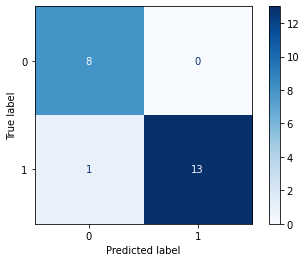

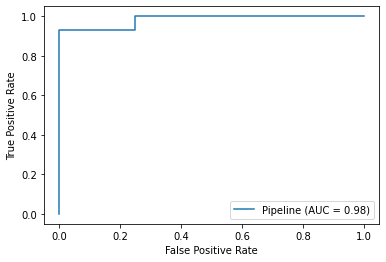

SCHH
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2011-01-13,19.1564,19.2631,19.1259,19.1716,13100,0.0000,0.0000,SCHH
2011-01-14,19.2097,19.3469,19.1716,19.3469,179800,0.0000,0.0000,SCHH
2011-01-18,19.3697,19.4916,19.2783,19.4916,60800,0.0000,0.0000,SCHH
2011-01-19,19.5221,19.5221,19.1869,19.2402,53900,0.0000,0.0000,SCHH
2011-01-20,19.2402,19.4155,19.2097,19.2631,21300,0.0000,0.0000,SCHH
...,...,...,...,...,...,...,...,...
2021-06-17,46.1771,46.3264,45.9680,46.2667,891700,0.0000,0.0000,SCHH
2021-06-18,46.0178,46.2368,45.4801,45.5100,1032500,0.0000,0.0000,SCHH
2021-06-21,45.7191,46.5355,45.5200,46.4260,609700,0.0000,0.0000,SCHH


MAE: 0.3267
RMSE: 0.4127
R^2: 0.7970


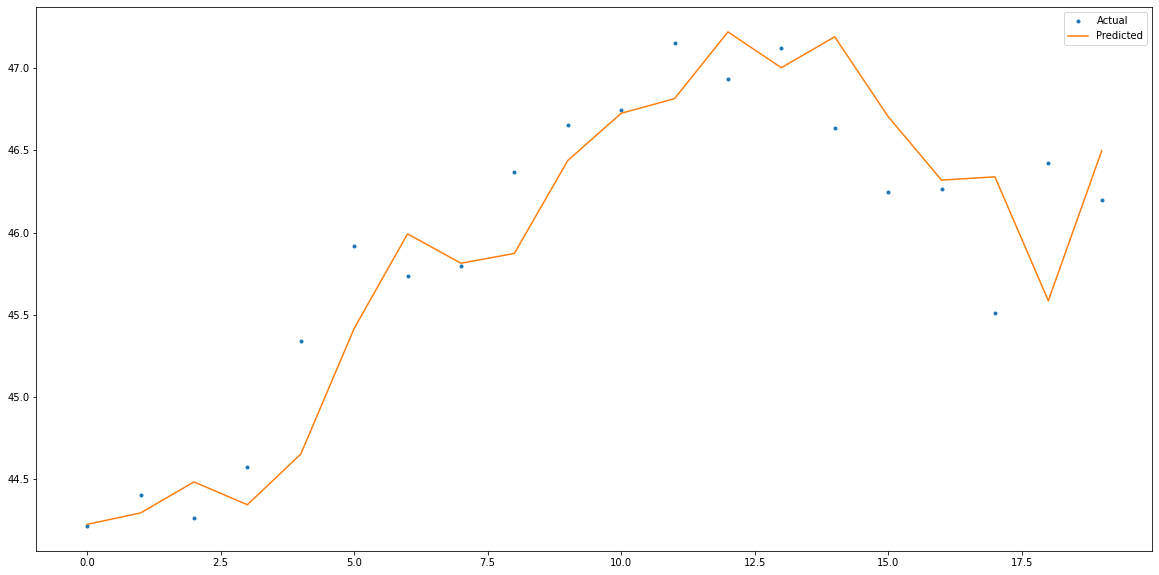

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2011-01-14,19.2097,19.3469,19.1716,19.3469,up
2011-01-18,19.3697,19.4916,19.2783,19.4916,up
2011-01-19,19.5221,19.5221,19.1869,19.2402,down
2011-01-20,19.2402,19.4155,19.2097,19.2631,up
2011-01-21,19.3545,19.4307,19.2554,19.3088,up
...,...,...,...,...,...
2021-06-17,46.1771,46.3264,45.9680,46.2667,up
2021-06-18,46.0178,46.2368,45.4801,45.5100,down
2021-06-21,45.7191,46.5355,45.5200,46.4260,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.9091
roc-auc: 0.9911
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.93      0.93      0.93        14

    accuracy                           0.91        22
   macro avg       0.90      0.90      0.90        22
weighted avg       0.91      0.91      0.91        22



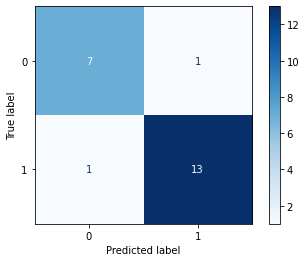

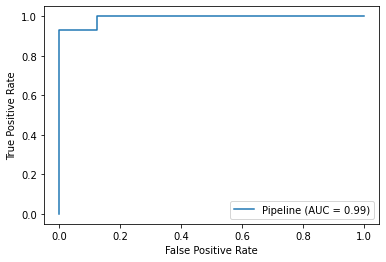

ICF
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2001-02-02,8.8871,8.8871,8.8871,8.8871,4800,0.0000,0.0000,ICF
2001-02-05,8.9097,8.9097,8.8819,8.8819,3200,0.0000,0.0000,ICF
2001-02-06,8.8471,8.8471,8.8471,8.8471,400,0.0000,0.0000,ICF
2001-02-07,8.8107,8.8107,8.8107,8.8107,800,0.0000,0.0000,ICF
2001-02-08,8.7724,8.7724,8.7672,8.7672,1600,0.0000,0.0000,ICF
...,...,...,...,...,...,...,...,...
2021-06-17,65.4600,66.0500,65.4600,65.9800,192600,0.0000,0.0000,ICF
2021-06-18,65.7800,66.0100,65.0000,65.0000,130800,0.0000,0.0000,ICF
2021-06-21,65.3300,66.4200,64.9100,66.2400,153100,0.0000,0.0000,ICF


MAE: 0.4575
RMSE: 0.5758
R^2: 0.8336


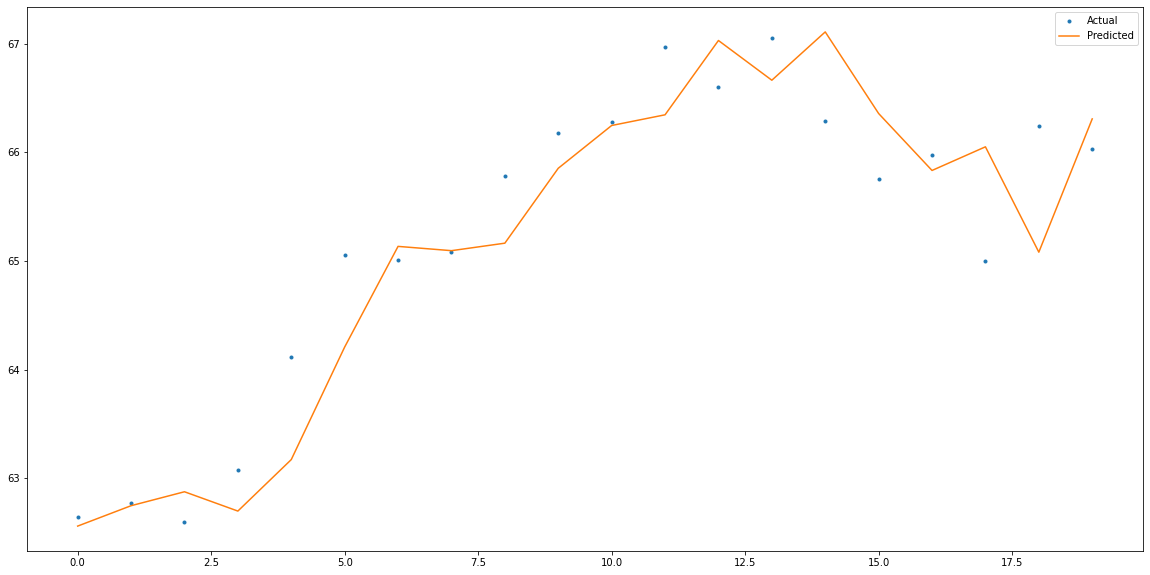

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2001-02-05,8.9097,8.9097,8.8819,8.8819,down
2001-02-06,8.8471,8.8471,8.8471,8.8471,down
2001-02-07,8.8107,8.8107,8.8107,8.8107,down
2001-02-08,8.7724,8.7724,8.7672,8.7672,down
2001-02-09,8.7203,8.7203,8.7099,8.7099,down
...,...,...,...,...,...
2021-06-17,65.4600,66.0500,65.4600,65.9800,up
2021-06-18,65.7800,66.0100,65.0000,65.0000,down
2021-06-21,65.3300,66.4200,64.9100,66.2400,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.7727
roc-auc: 0.9554
              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.91      0.71      0.80        14

    accuracy                           0.77        22
   macro avg       0.77      0.79      0.77        22
weighted avg       0.81      0.77      0.78        22



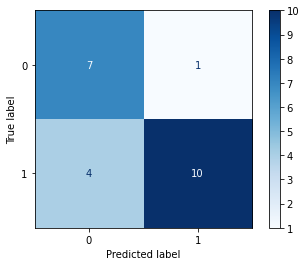

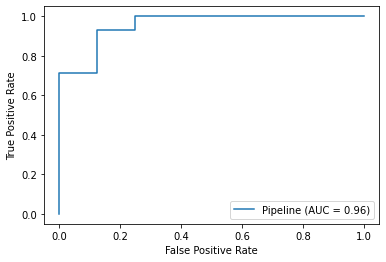

USRT
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2007-05-04,27.8447,27.8837,27.6829,27.6941,4100,0.0000,0.0000,USRT
2007-05-07,27.7443,27.7443,27.7220,27.7220,3300,0.0000,0.0000,USRT
2007-05-08,27.6439,27.6439,27.5379,27.5491,5000,0.0000,0.0000,USRT
2007-05-09,27.8781,27.8781,27.7777,27.7777,4000,0.0000,0.0000,USRT
2007-05-10,27.7443,27.7945,27.4822,27.4822,10000,0.0000,0.0000,USRT
...,...,...,...,...,...,...,...,...
2021-06-17,59.2400,59.4000,58.7300,59.1300,186700,0.0000,0.0000,USRT
2021-06-18,58.9000,59.0600,58.0700,58.0700,199200,0.0000,0.0000,USRT
2021-06-21,58.2500,59.5200,58.1200,59.3200,187300,0.0000,0.0000,USRT


MAE: 0.4590
RMSE: 0.5658
R^2: 0.8040


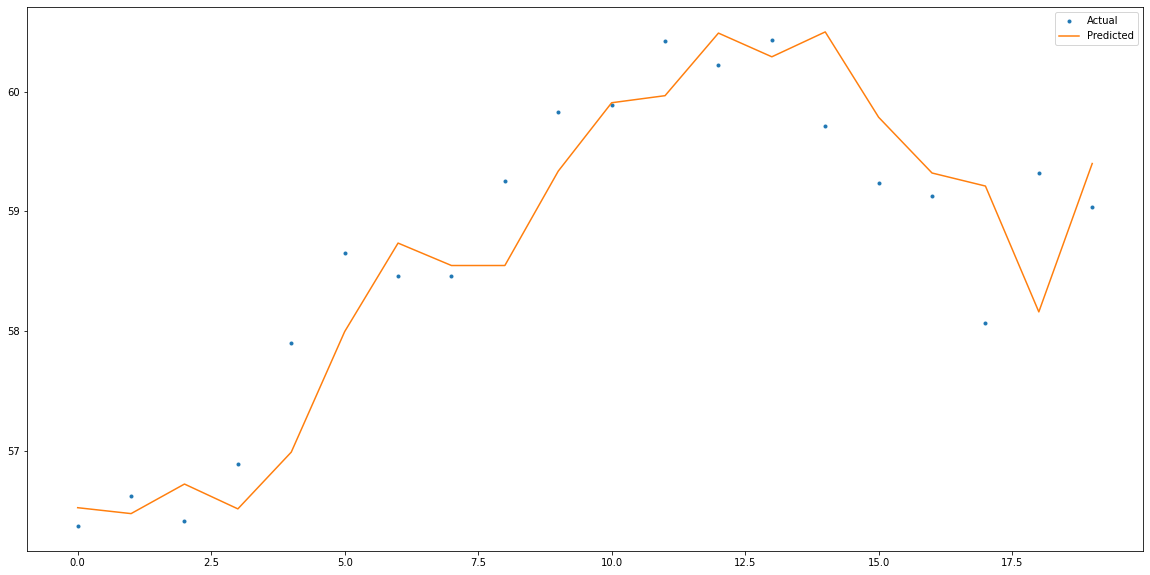

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2007-05-07,27.7443,27.7443,27.7220,27.7220,up
2007-05-08,27.6439,27.6439,27.5379,27.5491,down
2007-05-09,27.8781,27.8781,27.7777,27.7777,up
2007-05-10,27.7443,27.7945,27.4822,27.4822,down
2007-05-11,27.6327,27.8335,27.6327,27.8335,up
...,...,...,...,...,...
2021-06-17,59.2400,59.4000,58.7300,59.1300,down
2021-06-18,58.9000,59.0600,58.0700,58.0700,down
2021-06-21,58.2500,59.5200,58.1200,59.3200,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.9545
roc-auc: 0.9917
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.91      0.95        11

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22



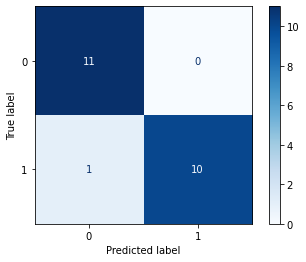

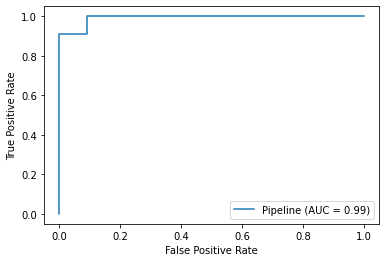

RWR
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2001-08-27,18.9390,18.9390,18.9390,18.9390,0,0.0000,0.0000,RWR
2001-08-28,18.9390,18.9390,18.9390,18.9390,0,0.0000,0.0000,RWR
2001-08-29,18.6545,18.6545,18.5228,18.5752,13800,0.0000,0.0000,RWR
2001-08-30,18.4913,18.4913,18.4913,18.4913,3000,0.0000,0.0000,RWR
2001-08-31,18.4479,18.4479,18.4479,18.4479,900,0.0000,0.0000,RWR
...,...,...,...,...,...,...,...,...
2021-06-17,106.2895,106.5477,105.5842,106.2398,90800,0.0000,0.0000,RWR
2021-06-18,105.7630,106.1305,104.2531,104.2630,785300,0.0000,0.0000,RWR
2021-06-21,104.7700,107.0000,104.5100,106.7200,180900,0.6970,0.0000,RWR


MAE: 0.8603
RMSE: 1.0646
R^2: 0.7603


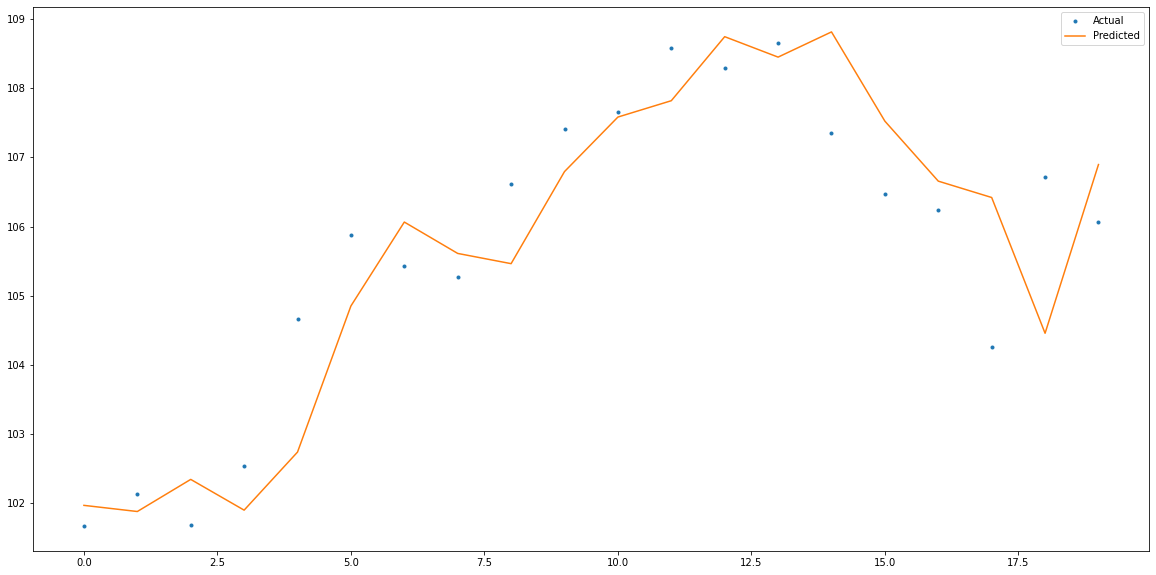

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2001-08-28,18.9390,18.9390,18.9390,18.9390,down
2001-08-29,18.6545,18.6545,18.5228,18.5752,down
2001-08-30,18.4913,18.4913,18.4913,18.4913,down
2001-08-31,18.4479,18.4479,18.4479,18.4479,down
2001-09-04,18.4195,18.4195,18.4195,18.4195,down
...,...,...,...,...,...
2021-06-17,106.2895,106.5477,105.5842,106.2398,down
2021-06-18,105.7630,106.1305,104.2531,104.2630,down
2021-06-21,104.7700,107.0000,104.5100,106.7200,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.9545
roc-auc: 0.9917
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.92      1.00      0.96        12

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22



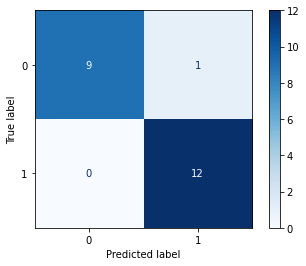

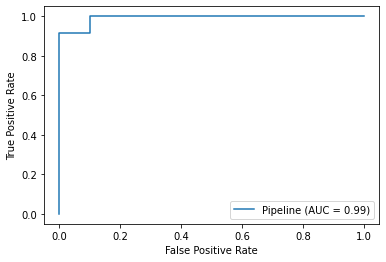

REM
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2007-05-04,42.2580,42.2580,42.1235,42.1824,1700,0.0000,0.0000,REM
2007-05-07,42.2328,42.3757,42.1739,42.1739,2800,0.0000,0.0000,REM
2007-05-08,41.9218,42.0227,41.7033,42.0227,1900,0.0000,0.0000,REM
2007-05-09,42.2244,42.3253,42.1403,42.2748,2700,0.0000,0.0000,REM
2007-05-10,42.3000,42.3000,41.7537,41.7874,5100,0.0000,0.0000,REM
...,...,...,...,...,...,...,...,...
2021-06-17,37.7000,37.8500,36.5700,36.9900,993100,0.0000,0.0000,REM
2021-06-18,36.7300,36.8100,36.0900,36.4200,811400,0.0000,0.0000,REM
2021-06-21,36.7300,37.2800,36.5400,37.2400,564800,0.0000,0.0000,REM


MAE: 0.3174
RMSE: 0.3787
R^2: 0.6797


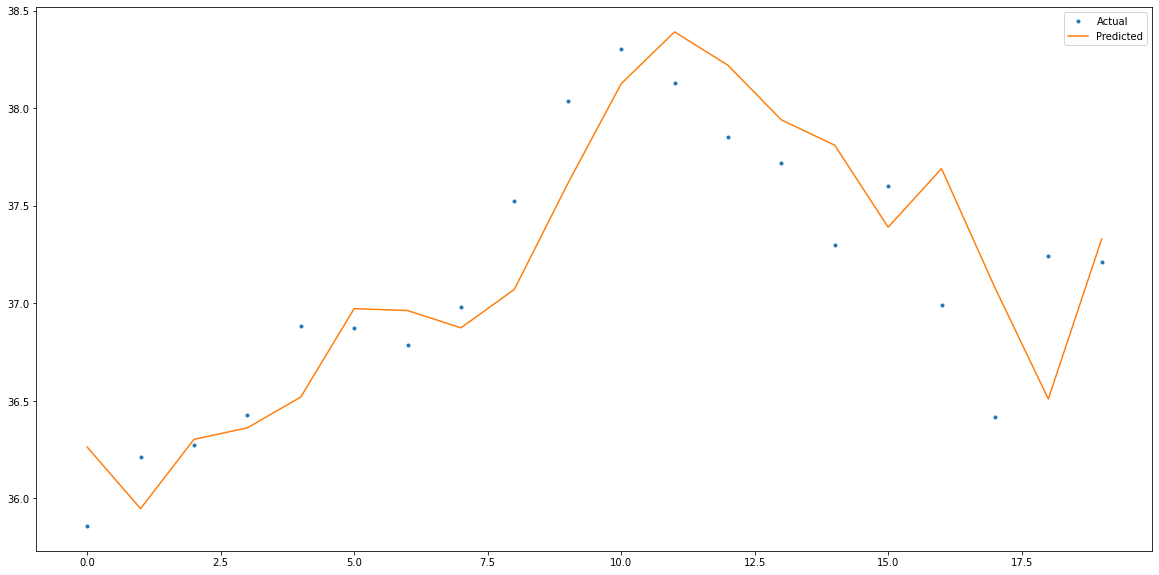

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2007-05-07,42.2328,42.3757,42.1739,42.1739,down
2007-05-08,41.9218,42.0227,41.7033,42.0227,down
2007-05-09,42.2244,42.3253,42.1403,42.2748,up
2007-05-10,42.3000,42.3000,41.7537,41.7874,down
2007-05-11,41.9975,42.0899,41.9975,42.0899,up
...,...,...,...,...,...
2021-06-17,37.7000,37.8500,36.5700,36.9900,down
2021-06-18,36.7300,36.8100,36.0900,36.4200,down
2021-06-21,36.7300,37.2800,36.5400,37.2400,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.8182
roc-auc: 0.9917
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.75      1.00      0.86        12

    accuracy                           0.82        22
   macro avg       0.88      0.80      0.80        22
weighted avg       0.86      0.82      0.81        22



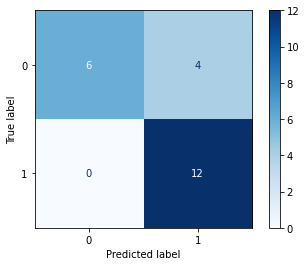

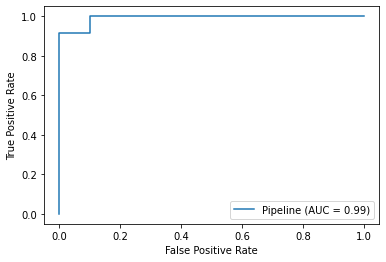

REZ
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2007-05-04,27.9687,27.9687,27.8151,27.8151,10000,0.0000,0.0000,REZ
2007-05-07,27.9232,27.9232,27.9232,27.9232,2000,0.0000,0.0000,REZ
2007-05-08,27.9744,27.9744,27.9744,27.9744,200,0.0000,0.0000,REZ
2007-05-09,27.9346,27.9346,27.9346,27.9346,2000,0.0000,0.0000,REZ
2007-05-10,28.2817,28.2817,28.1053,28.1053,8000,0.0000,0.0000,REZ
...,...,...,...,...,...,...,...,...
2021-06-17,83.3800,83.6900,82.9600,83.6500,67700,0.0000,0.0000,REZ
2021-06-18,83.1700,83.6900,82.1900,82.1900,44900,0.0000,0.0000,REZ
2021-06-21,82.6300,84.3000,82.3800,84.0900,41300,0.0000,0.0000,REZ


MAE: 0.5915
RMSE: 0.7644
R^2: 0.7894


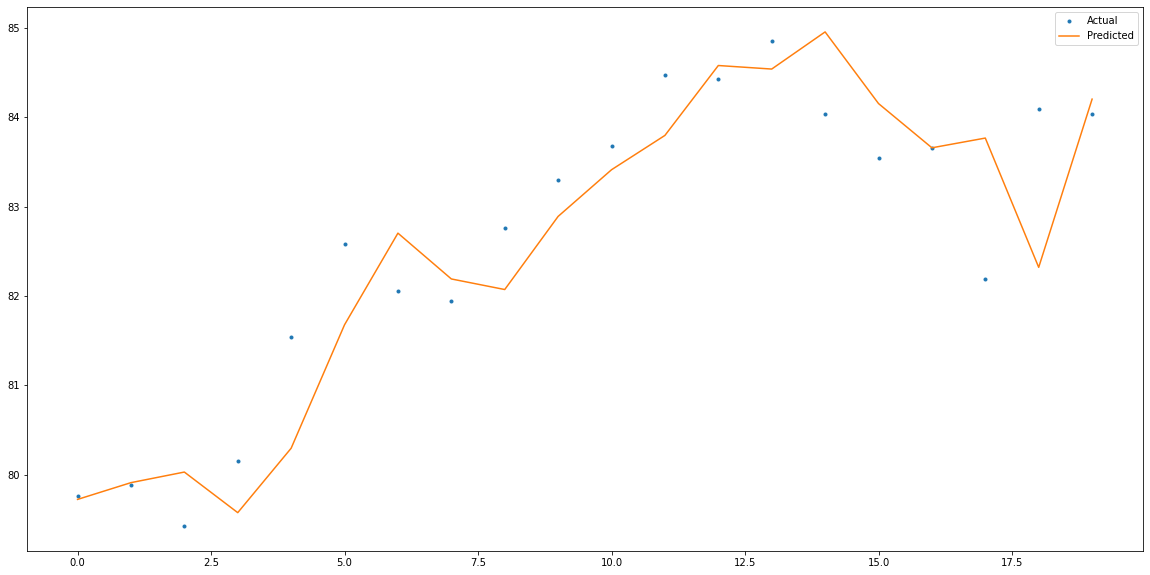

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2007-05-07,27.9232,27.9232,27.9232,27.9232,up
2007-05-08,27.9744,27.9744,27.9744,27.9744,up
2007-05-09,27.9346,27.9346,27.9346,27.9346,down
2007-05-10,28.2817,28.2817,28.1053,28.1053,up
2007-05-11,29.0385,29.1296,28.9304,29.1296,up
...,...,...,...,...,...
2021-06-17,83.3800,83.6900,82.9600,83.6500,up
2021-06-18,83.1700,83.6900,82.1900,82.1900,down
2021-06-21,82.6300,84.3000,82.3800,84.0900,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.9091
roc-auc: 0.9643
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.86      0.92        14

    accuracy                           0.91        22
   macro avg       0.90      0.93      0.91        22
weighted avg       0.93      0.91      0.91        22



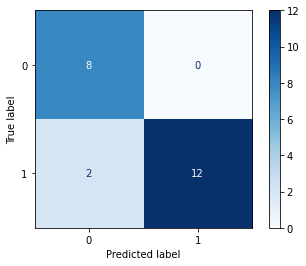

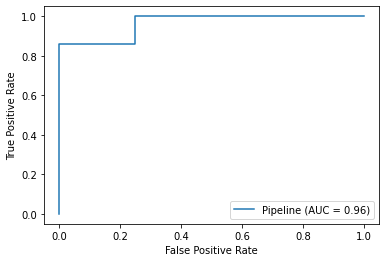

KBWY
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2010-12-02,12.4566,12.5873,12.4566,12.5873,5400,0.0000,0.0000,KBWY
2010-12-03,12.6928,12.6928,12.5370,12.5822,6700,0.0000,0.0000,KBWY
2010-12-06,12.5873,12.5873,12.5873,12.5873,1600,0.0000,0.0000,KBWY
2010-12-07,12.6425,12.7782,12.6425,12.7280,8600,0.0000,0.0000,KBWY
2010-12-08,12.7279,12.7279,12.5621,12.5621,2000,0.0000,0.0000,KBWY
...,...,...,...,...,...,...,...,...
2021-06-17,23.6127,23.6127,23.1747,23.3639,250700,0.0000,0.0000,KBWY
2021-06-18,23.2444,23.2942,22.6670,22.6770,273900,0.0000,0.0000,KBWY
2021-06-21,22.8000,23.3200,22.7400,23.2200,191000,0.1030,0.0000,KBWY


MAE: 0.2171
RMSE: 0.2735
R^2: 0.6631


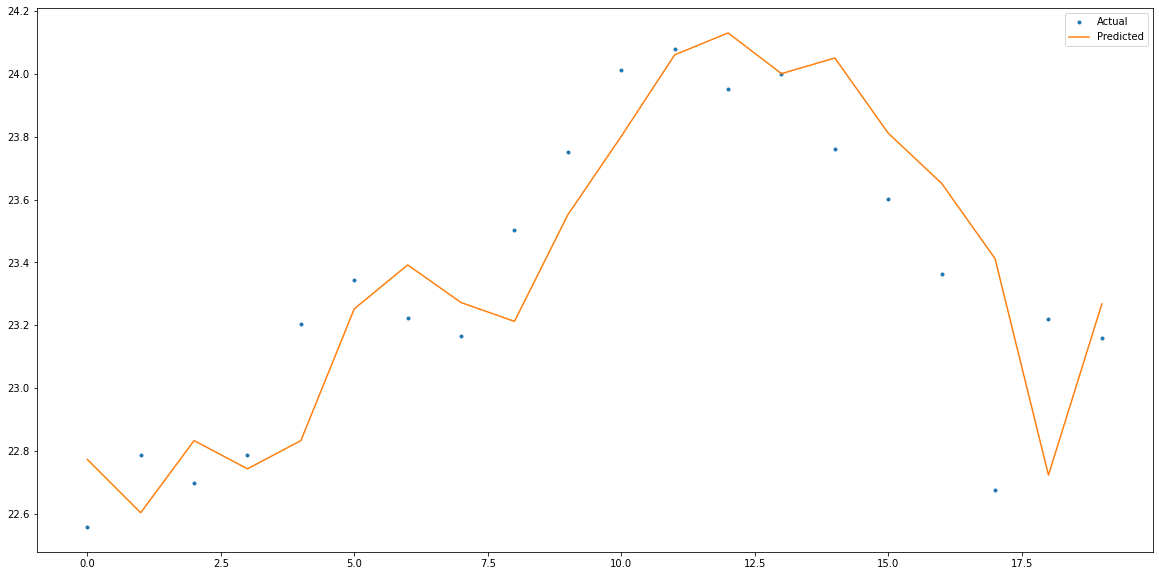

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2010-12-03,12.6928,12.6928,12.5370,12.5822,down
2010-12-06,12.5873,12.5873,12.5873,12.5873,up
2010-12-07,12.6425,12.7782,12.6425,12.7280,up
2010-12-08,12.7279,12.7279,12.5621,12.5621,down
2010-12-09,12.5018,12.5068,12.4767,12.4767,down
...,...,...,...,...,...
2021-06-17,23.6127,23.6127,23.1747,23.3639,down
2021-06-18,23.2444,23.2942,22.6670,22.6770,down
2021-06-21,22.8000,23.3200,22.7400,23.2200,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.5000
roc-auc: 0.9669
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.50      1.00      0.67        11

    accuracy                           0.50        22
   macro avg       0.25      0.50      0.33        22
weighted avg       0.25      0.50      0.33        22



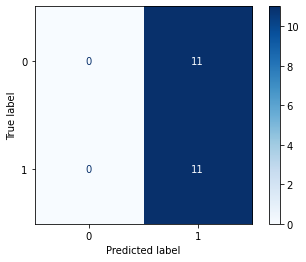

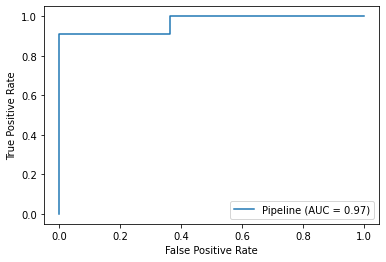

MORT
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2011-08-17,10.1614,10.7711,10.1208,10.1492,19800,0.0000,0.0000,MORT
2011-08-18,10.1980,10.1980,9.7550,9.8038,54000,0.0000,0.0000,MORT
2011-08-19,9.7468,9.8525,9.6330,9.6330,41800,0.0000,0.0000,MORT
2011-08-22,9.7550,9.7916,9.5517,9.6737,18000,0.0000,0.0000,MORT
2011-08-23,10.1574,10.1574,9.6778,9.8769,21200,0.0000,0.0000,MORT
...,...,...,...,...,...,...,...,...
2021-06-17,20.2400,20.3000,19.6300,19.8900,296900,0.0000,0.0000,MORT
2021-06-18,19.7300,19.7400,19.3600,19.5300,190300,0.0000,0.0000,MORT
2021-06-21,19.6900,19.9900,19.5900,19.9700,131100,0.0000,0.0000,MORT


MAE: 0.1721
RMSE: 0.2105
R^2: 0.6827


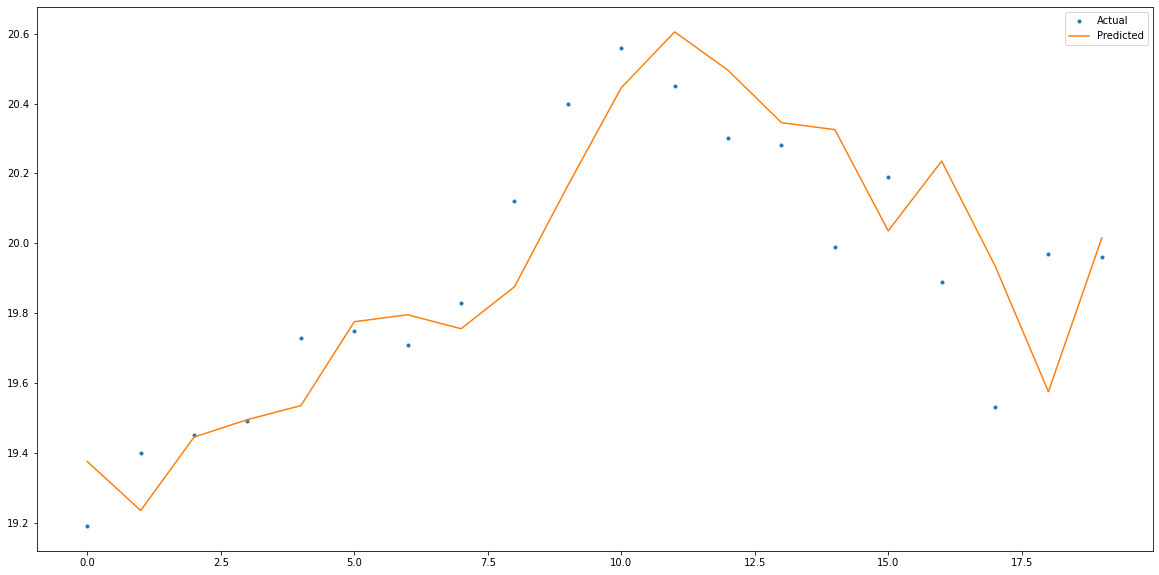

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2011-08-18,10.1980,10.1980,9.7550,9.8038,down
2011-08-19,9.7468,9.8525,9.6330,9.6330,down
2011-08-22,9.7550,9.7916,9.5517,9.6737,up
2011-08-23,10.1574,10.1574,9.6778,9.8769,up
2011-08-24,10.0314,10.0314,9.6899,9.7834,down
...,...,...,...,...,...
2021-06-17,20.2400,20.3000,19.6300,19.8900,down
2021-06-18,19.7300,19.7400,19.3600,19.5300,down
2021-06-21,19.6900,19.9900,19.5900,19.9700,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.5455
roc-auc: 0.9667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.55      1.00      0.71        12

    accuracy                           0.55        22
   macro avg       0.27      0.50      0.35        22
weighted avg       0.30      0.55      0.39        22



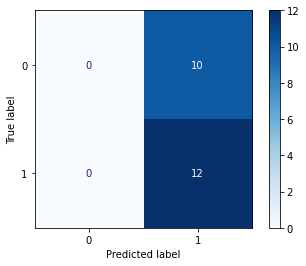

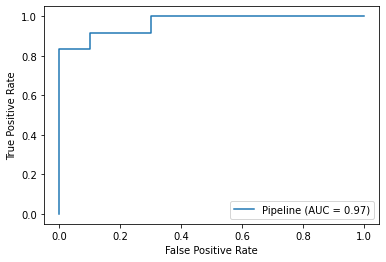

PSR
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2008-11-21,14.8984,15.3736,14.8984,15.3736,200,0.0000,0.0000,PSR
2008-11-24,15.3736,15.3736,15.3736,15.3736,0,0.0000,0.0000,PSR
2008-11-25,15.3736,15.3736,15.3736,15.3736,0,0.0000,0.0000,PSR
2008-11-26,15.3736,15.3736,15.3736,15.3736,0,0.0000,0.0000,PSR
2008-11-28,15.3736,15.3736,15.3736,15.3736,0,0.0000,0.0000,PSR
...,...,...,...,...,...,...,...,...
2021-06-17,104.1468,104.4150,103.7991,104.4150,3400,0.0000,0.0000,PSR
2021-06-18,103.6501,103.9183,102.9150,102.9150,4700,0.0000,0.0000,PSR
2021-06-21,103.1300,104.9300,103.1300,104.6300,5700,0.6850,0.0000,PSR


MAE: 0.7245
RMSE: 0.8927
R^2: 0.8320


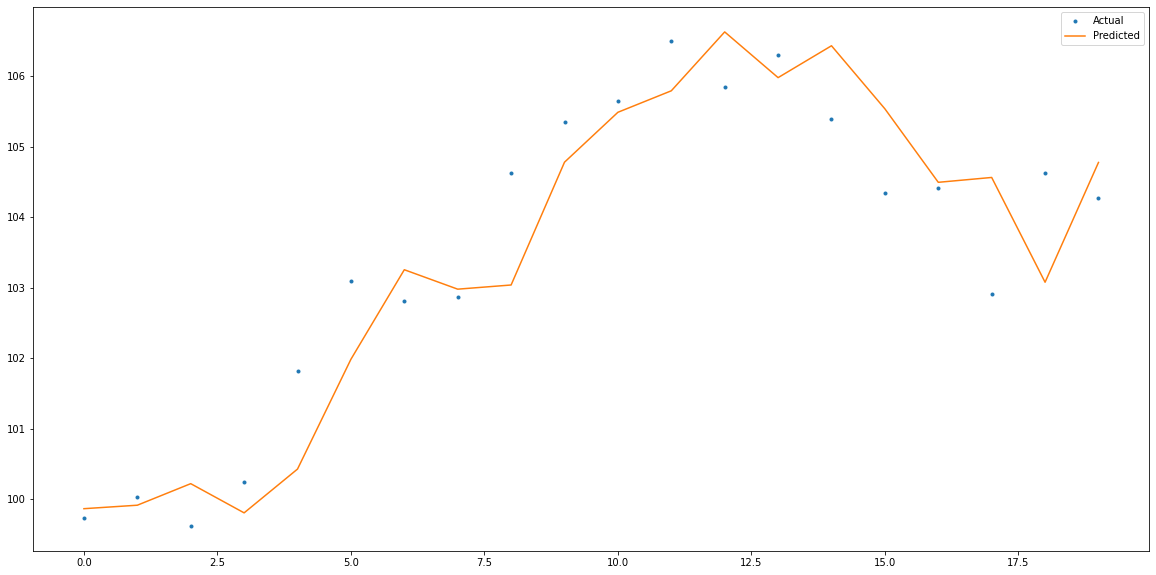

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2008-11-24,15.3736,15.3736,15.3736,15.3736,down
2008-11-25,15.3736,15.3736,15.3736,15.3736,down
2008-11-26,15.3736,15.3736,15.3736,15.3736,down
2008-11-28,15.3736,15.3736,15.3736,15.3736,down
2008-12-01,15.3736,15.3736,15.3736,15.3736,down
...,...,...,...,...,...
2021-06-17,104.1468,104.4150,103.7991,104.4150,up
2021-06-18,103.6501,103.9183,102.9150,102.9150,down
2021-06-21,103.1300,104.9300,103.1300,104.6300,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.9091
roc-auc: 0.9107
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.88      1.00      0.93        14

    accuracy                           0.91        22
   macro avg       0.94      0.88      0.90        22
weighted avg       0.92      0.91      0.91        22



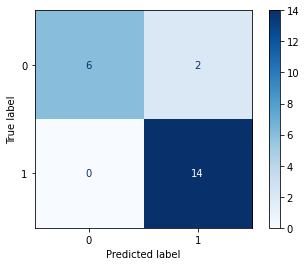

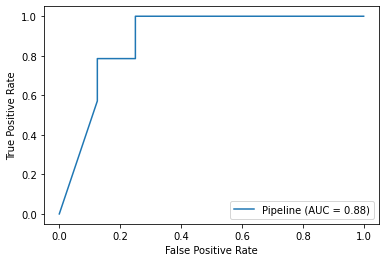

FRI
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2007-05-10,13.8404,13.8404,13.7923,13.7923,3100,0.0000,0.0000,FRI
2007-05-11,13.8747,13.8747,13.8060,13.8266,10000,0.0000,0.0000,FRI
2007-05-14,13.8884,13.9022,13.7923,13.7923,13000,0.0000,0.0000,FRI
2007-05-15,13.8060,13.8060,13.6207,13.6207,7000,0.0000,0.0000,FRI
2007-05-16,13.6069,13.6069,13.4216,13.4490,12600,0.0000,0.0000,FRI
...,...,...,...,...,...,...,...,...
2021-06-17,28.5000,28.5300,28.3600,28.5100,16100,0.0000,0.0000,FRI
2021-06-18,28.3600,28.3900,28.0000,28.0200,38000,0.0000,0.0000,FRI
2021-06-21,28.0900,28.6800,28.0900,28.6100,16200,0.0000,0.0000,FRI


MAE: 0.2160
RMSE: 0.2672
R^2: 0.8124


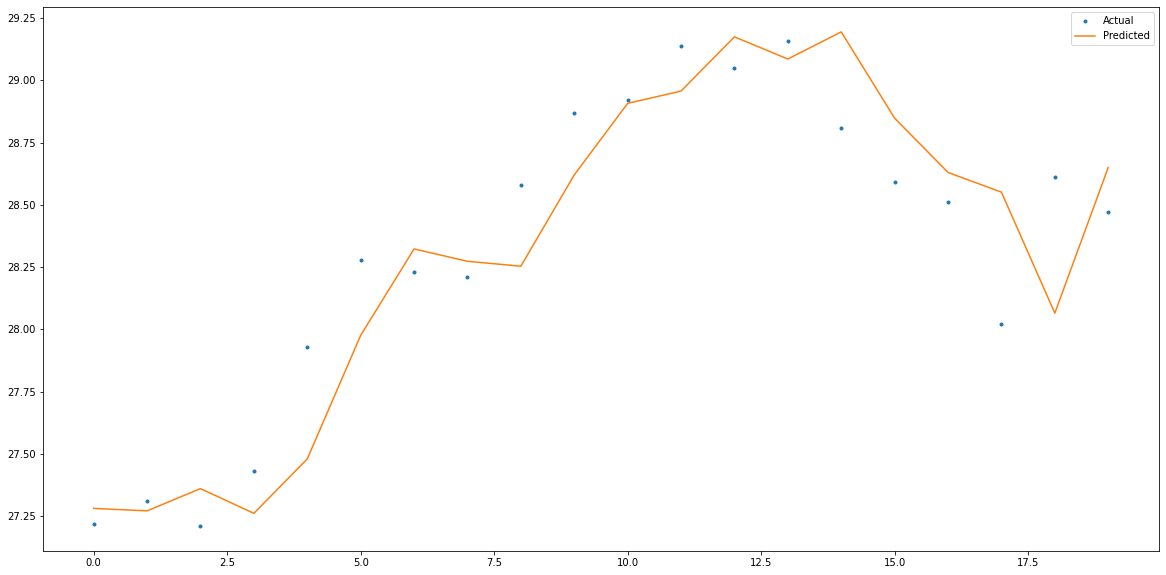

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2007-05-11,13.8747,13.8747,13.8060,13.8266,up
2007-05-14,13.8884,13.9022,13.7923,13.7923,down
2007-05-15,13.8060,13.8060,13.6207,13.6207,down
2007-05-16,13.6069,13.6069,13.4216,13.4490,down
2007-05-17,13.2637,13.2637,13.2568,13.2568,down
...,...,...,...,...,...
2021-06-17,28.5000,28.5300,28.3600,28.5100,down
2021-06-18,28.3600,28.3900,28.0000,28.0200,down
2021-06-21,28.0900,28.6800,28.0900,28.6100,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.5000
roc-auc: 0.9669
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.50      1.00      0.67        11

    accuracy                           0.50        22
   macro avg       0.25      0.50      0.33        22
weighted avg       0.25      0.50      0.33        22



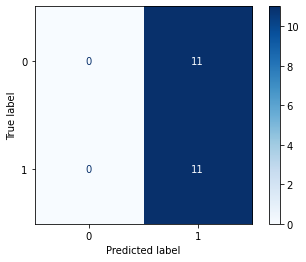

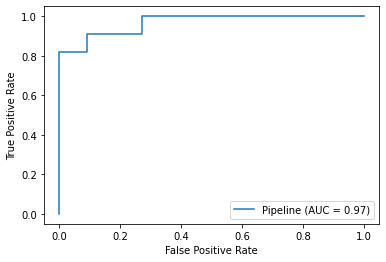

ROOF
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2011-06-14,11.6071,11.6819,11.5956,11.6589,46100,0.0000,0.0000,ROOF
2011-06-15,11.5783,11.5783,11.3885,11.4058,25700,0.0000,0.0000,ROOF
2011-06-16,11.6071,11.6416,11.4748,11.5668,32400,0.0000,0.0000,ROOF
2011-06-17,11.6761,11.7624,11.6531,11.6589,19600,0.0000,0.0000,ROOF
2011-06-20,11.7106,11.7969,11.7106,11.7624,13400,0.0000,0.0000,ROOF
...,...,...,...,...,...,...,...,...
2021-06-17,26.6638,26.6836,26.2178,26.3962,13200,0.0000,0.0000,ROOF
2021-06-18,26.1979,26.1979,25.8510,25.8510,3600,0.0000,0.0000,ROOF
2021-06-21,26.0200,26.5400,26.0200,26.4600,3600,0.2290,0.0000,ROOF


MAE: 0.2576
RMSE: 0.3274
R^2: 0.7859


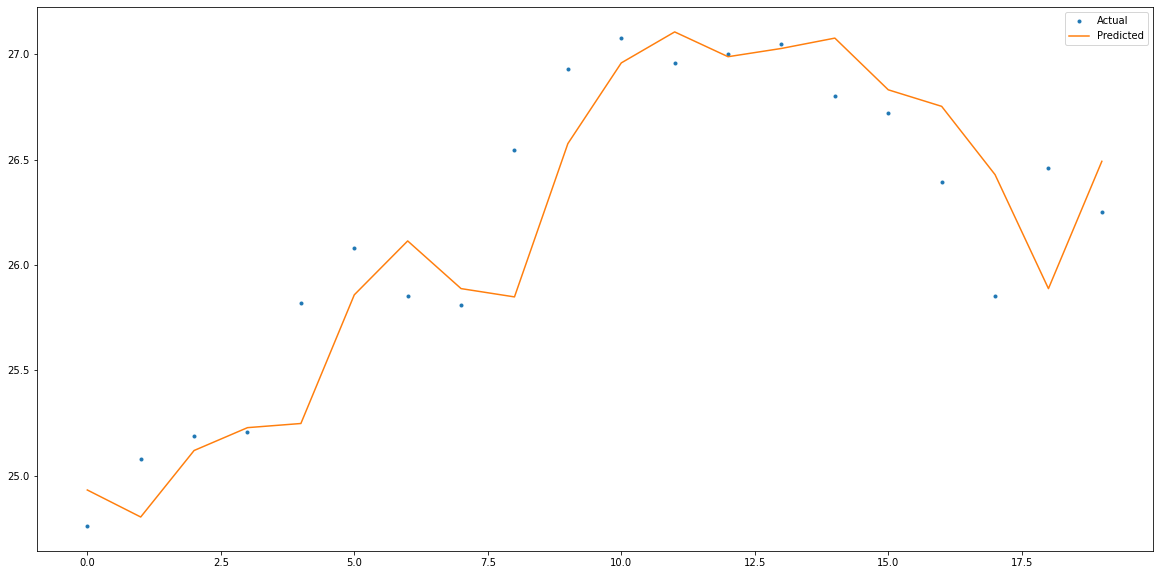

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2011-06-15,11.5783,11.5783,11.3885,11.4058,down
2011-06-16,11.6071,11.6416,11.4748,11.5668,up
2011-06-17,11.6761,11.7624,11.6531,11.6589,up
2011-06-20,11.7106,11.7969,11.7106,11.7624,up
2011-06-21,11.8659,11.9062,11.8372,11.9062,up
...,...,...,...,...,...
2021-06-17,26.6638,26.6836,26.2178,26.3962,down
2021-06-18,26.1979,26.1979,25.8510,25.8510,down
2021-06-21,26.0200,26.5400,26.0200,26.4600,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.5909
roc-auc: 1.0000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.59      1.00      0.74        13

    accuracy                           0.59        22
   macro avg       0.30      0.50      0.37        22
weighted avg       0.35      0.59      0.44        22



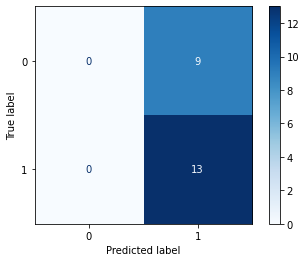

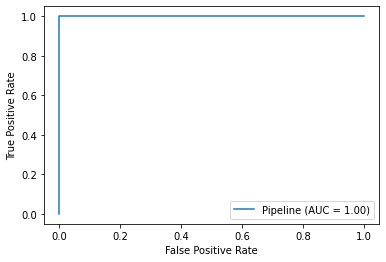

RDOG
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2008-05-22,28.4241,28.4300,28.3826,28.4004,2300,0.0000,0.0000,RDOG
2008-05-23,28.4241,28.4241,28.3412,28.3412,1300,0.0000,0.0000,RDOG
2008-05-27,28.1931,28.1931,28.1931,28.1931,5100,0.0000,0.0000,RDOG
2008-05-28,28.4004,28.4004,28.3293,28.3708,6000,0.0000,0.0000,RDOG
2008-05-29,28.2405,28.4004,28.2405,28.4004,3000,0.0000,0.0000,RDOG
...,...,...,...,...,...,...,...,...
2021-06-17,48.5200,48.5200,48.1600,48.4200,1000,0.4730,0.0000,RDOG
2021-06-18,47.8900,47.8900,47.4600,47.4600,1000,0.0000,0.0000,RDOG
2021-06-21,47.5600,48.4000,47.5600,48.4000,800,0.0000,0.0000,RDOG


MAE: 0.4261
RMSE: 0.5212
R^2: 0.7853


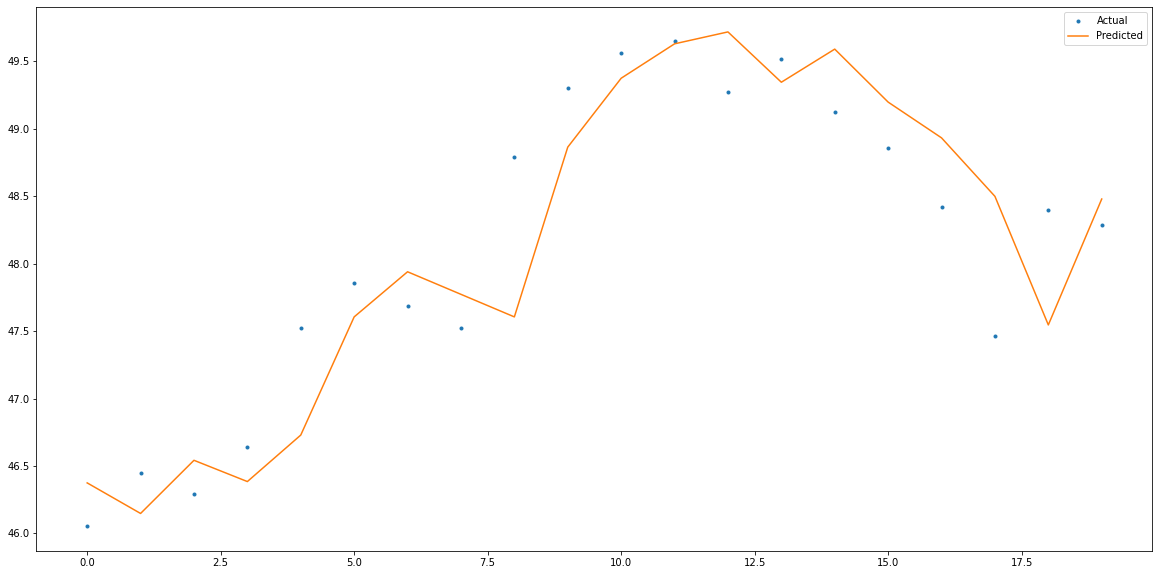

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2008-05-23,28.4241,28.4241,28.3412,28.3412,down
2008-05-27,28.1931,28.1931,28.1931,28.1931,down
2008-05-28,28.4004,28.4004,28.3293,28.3708,up
2008-05-29,28.2405,28.4004,28.2405,28.4004,up
2008-05-30,28.5663,28.5663,28.3412,28.5366,up
...,...,...,...,...,...
2021-06-17,48.5200,48.5200,48.1600,48.4200,down
2021-06-18,47.8900,47.8900,47.4600,47.4600,down
2021-06-21,47.5600,48.4000,47.5600,48.4000,up


Test
-*-*-*-*-*-*-*-*
accuracy: 0.6364
roc-auc: 0.7025
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.62      0.73      0.67        11

    accuracy                           0.64        22
   macro avg       0.64      0.64      0.63        22
weighted avg       0.64      0.64      0.63        22



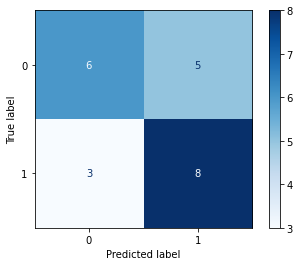

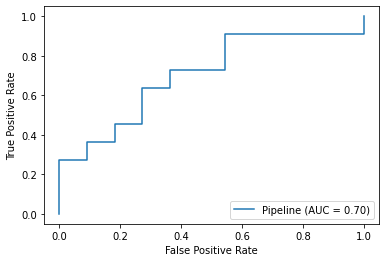

REK
This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2010-03-18,48.6183,48.6183,48.2643,48.5102,1000,0.0000,0.0000,REK
2010-03-19,48.4610,49.1789,48.4610,49.0314,62700,0.0000,0.0000,REK
2010-03-22,49.5230,49.5230,48.4708,48.6380,36800,0.0000,0.0000,REK
2010-03-23,48.5200,48.8838,48.5200,48.7560,1500,0.0000,0.0000,REK
2010-03-24,48.7560,48.7560,48.7560,48.7560,0,0.0000,0.0000,REK
...,...,...,...,...,...,...,...,...
2021-06-17,9.2800,9.2900,9.2200,9.2200,5200,0.0000,0.0000,REK
2021-06-18,9.3300,9.3700,9.2700,9.3700,22800,0.0000,0.0000,REK
2021-06-21,9.3200,9.3200,9.1700,9.1700,22900,0.0000,0.0000,REK


MAE: 0.1128
RMSE: 0.1342
R^2: 0.4256


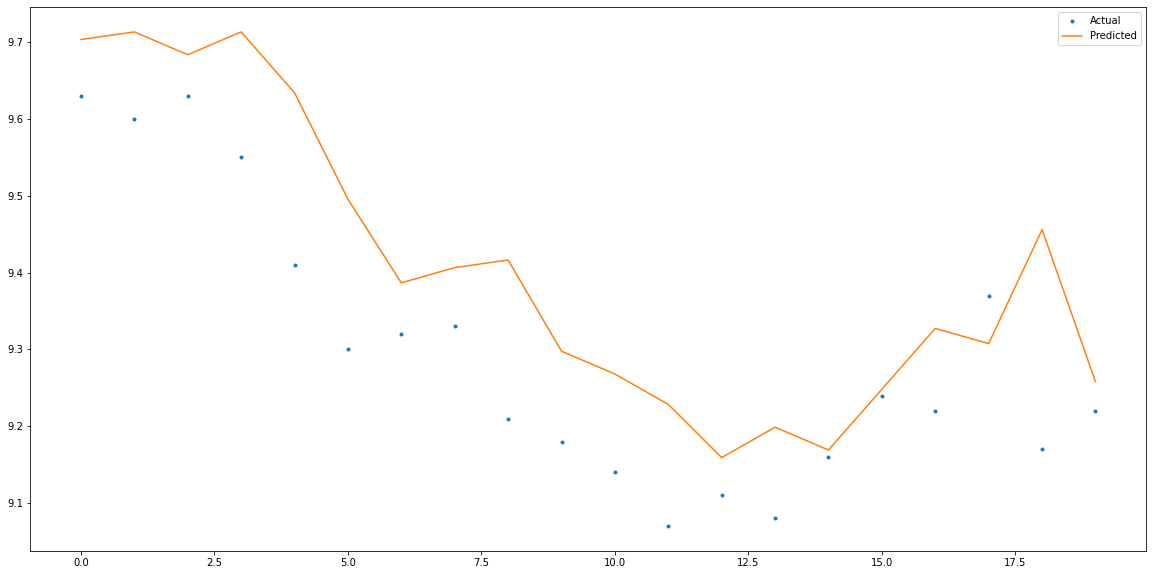

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2010-03-19,48.4610,49.1789,48.4610,49.0314,up
2010-03-22,49.5230,49.5230,48.4708,48.6380,down
2010-03-23,48.5200,48.8838,48.5200,48.7560,up
2010-03-24,48.7560,48.7560,48.7560,48.7560,down
2010-03-25,48.2053,48.2742,47.7726,47.8611,down
...,...,...,...,...,...
2021-06-17,9.2800,9.2900,9.2200,9.2200,down
2021-06-18,9.3300,9.3700,9.2700,9.3700,up
2021-06-21,9.3200,9.3200,9.1700,9.1700,down


Test
-*-*-*-*-*-*-*-*
accuracy: 0.4545
roc-auc: 0.9667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.45      1.00      0.62        10

    accuracy                           0.45        22
   macro avg       0.23      0.50      0.31        22
weighted avg       0.21      0.45      0.28        22



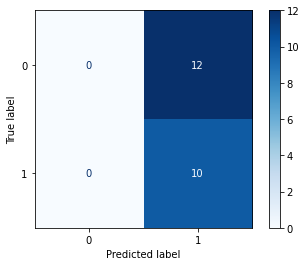

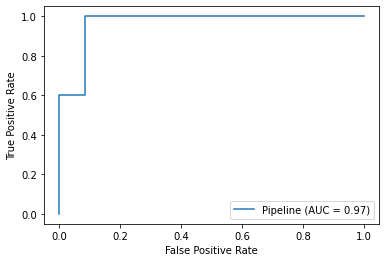

In [13]:
# Loop all the ticker symbol in defined function
for symbol in ticker:
    print(symbol)
    etf(symbol)

## VII. Evaluation

|  Model | MAE | RMSE | R^2 | Accuracy | F1(0) | F1(1) |
| :---: | :---: |:---: | :---: | :---: | :---: | :---: |
| VNQ | 0.7335 | 0.9228 | 0.7897 | 0.9091 | 0.90 | 0.92 |
| IYR | 0.6964 | 0.8815 | 0.7768 | 0.9545 | 0.94 | 0.96 |
| SCHH | 0.3267 | 0.4127 | 0.7970 | 0.9091 | 0.88 | 0.93 |
| ICF | 0.4575 | 0.5758 | 0.8336 | 0.7727 | 0.74 | 0.80 |
| USRT | 0.4590 | 0.5658 | 0.8040 | 0.9545 | 0.96 | 0.95 | 
| RWR | 0.8603 | 1.0646 | 0.7603 | 0.9545 | 0.95 | 0.96 |
| REM | 0.3174 | 0.3787 | 0.6797 | 0.8182 | 0.75 | 0.86 |
| REZ | 0.5915 | 0.7644| 0.7894| 0.9091 | 0.89 | 0.92 |
| KBWY | 0.2171 | 0.2735 | 0.6631 | 0.5000 | 0.00 | 0.67 |
| MORT | 0.1721 | 0.2105 | 0.6827 | 0.5455 | 0.00 | 0.71 |
| PSR | 0.7245 | 0.8927 | 0.8320 | 0.9091 | 0.86 | 0.93 |
| FRI | 0.2160 | 0.2672 | 0.8124 | 0.5000 | 0.00 | 0.67 |
| ROOF | 0.2576 | 0.3274 | 0.7859 | 0.5909 | 0.00 | 0.74 |
| RDOG | 0.4261 | 0.5212 | 0.7853 | 0.6364 | 0.60 | 0.67 |
| REK | 0.1128 | 0.1342 | 0.4256 | 0.4545 | 0.00 | 0.62 |


<b>Regression</b>
- The best LSTM model was applied to 15 REIT ETFs' test set. By looking at the MAE and RMSE, LSTM can handle forecasting well by maintain small predition errors. 
    - This could be due to the nature of LSTM. LSTM choose to remember relevant information and forget irrelevants during sequences processing 

<b>Clssification</b>
- The best NuSVC classifier was applied to 15 REIT ETFs' test set. By looking at the test accuracy, only 9 of 15 ETFs have acceptable results
    - This could be due to the nature of NuSVC classifier. For binary classification, NuSVC creates a hyperplane to separate different classes. The test size contains 22 days from 5/24/2021 to 6/23/2021. 15 ETFs' were in different price ranges. Those have a closer price range with VNQ are more likely to generate good results. In contrast, those price range far away from VNQ generate results that could below the expectation

## VIII. Conclusion

By analyzing and building models on VNQ time series, LSTM model was selected for regression and NuSVC model was selected for classification. Both models were applied to the rest of the 14 REIT ETFs to see how the model is generalizable for different time series. LSTM is a good fit for price prediction no matter the time series has either an increasing trend or a decreasing trend. NuSVC is more like to fit for time series which have a closer price range with VNQ.

### Recommendation
- <b>Update</b>: Update the model periodically so that the model can learn new pattern

### Future Work
Further analysis can be explored on the following to provide additional insights and improve the model performance.
- <b>Buy/Hold/Sell</b>: Create an alert when the prediction reaches certain point
- <b>Market Sentiment</b>: Web scrapping on social media to gather market information 
- <b>Extensive application</b>: Further develop models for other investment products with time series based
- <b>Model Deployment</b>: Automaticaly fetch new historical data, and run models for prediction